<a href="https://colab.research.google.com/github/sandeepkhannavp/SCL_PACKAGE_ARMA/blob/main/ARMA_SCL_20PT29.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

BY SANDEEP KHANNA V P - 20PT29

**Auto-Regressive Moving Average (ARMA)**

Implementing ARMA model from scratch

In [4]:
import warnings
import yfinance as ysf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [5]:
warnings.filterwarnings('ignore')

Setting start and end date to fetch stock market data

In [9]:
start_date = '2022-04-01'
end_date = '2022-11-01'

Setting the Stock Symbol

In [10]:
ticker = 'INFY'

Download the data

In [11]:
df = ysf.download(ticker, start_date, end_date)

[*********************100%***********************]  1 of 1 completed


In [12]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-04-01,25.120001,25.129999,24.540001,24.610001,24.076115,14712000
2022-04-04,24.559999,24.740000,24.540001,24.740000,24.203293,12357900
2022-04-05,24.500000,24.540001,24.270000,24.379999,23.851103,6293000
2022-04-06,23.910000,24.120001,23.740000,23.969999,23.449997,12373700
2022-04-07,23.750000,24.000000,23.670000,23.820000,23.303251,8337400


In [13]:
df.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace=True)

In [14]:
df.isna().sum()

Close    0
dtype: int64

In [15]:
df.head()

,Close
Date,
2022-04-01,24.610001
2022-04-04,24.740000
2022-04-05,24.379999
2022-04-06,23.969999
2022-04-07,23.820000


**Auto-Regression**

In [16]:
# Function to generate Auto Regressive Model
def AR(p,df):
  df_temp = df

  #Generating the lagged p terms
  for i in range(1,p+1):
    df_temp['Shifted_values_%d' % i ] = df_temp['Close'].shift(i)

  train_size = (int)(0.8 * df_temp.shape[0])

  #Breaking data set into test and training
  df_train = pd.DataFrame(df_temp[0:train_size])
  df_test = pd.DataFrame(df_temp[train_size:df.shape[0]])

  df_train_2 = df_train.dropna()
  #X contains the lagged values ,hence we skip the first column
  X_train = df_train_2.iloc[:,1:].values.reshape(-1,p)
  #Y contains the value,it is the first column
  y_train = df_train_2.iloc[:,0].values.reshape(-1,1)

  #Running linear regression to generate the coefficents of lagged terms
  from sklearn.linear_model import LinearRegression
  lr = LinearRegression()
  lr.fit(X_train,y_train)

  theta  = lr.coef_.T
  intercept = lr.intercept_
  df_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
  # df_train_2[['Value','Predicted_Values']].plot()

  X_test = df_test.iloc[:,1:].values.reshape(-1,p)
  df_test['Predicted_Values'] = X_test.dot(lr.coef_.T) + lr.intercept_
  # df_test[['Value','Predicted_Values']].plot()

  RMSE = np.sqrt(mean_squared_error(df_test['Close'], df_test['Predicted_Values']))

  print("The RMSE is :", RMSE,", Value of p : ",p)
  return [df_train_2,df_test,theta,intercept,RMSE]

**MOVING AVERAGE**

In [17]:
# Function to compute Moving Average
def MA(q,res):

  for i in range(1,q+1):
    res['Shifted_values_%d' % i ] = res['Residuals'].shift(i)

  train_size = (int)(0.8 * res.shape[0])

  res_train = pd.DataFrame(res[0:train_size])
  res_test = pd.DataFrame(res[train_size:res.shape[0]])

  res_train_2 = res_train.dropna()
  X_train = res_train_2.iloc[:,1:].values.reshape(-1,q)
  y_train = res_train_2.iloc[:,0].values.reshape(-1,1)

  from sklearn.linear_model import LinearRegression
  lr = LinearRegression()
  lr.fit(X_train,y_train)

  theta  = lr.coef_.T
  intercept = lr.intercept_
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
  # res_train_2[['Residuals','Predicted_Values']].plot()

  X_test = res_test.iloc[:,1:].values.reshape(-1,q)
  res_test['Predicted_Values'] = X_test.dot(lr.coef_.T) + lr.intercept_
  res_test[['Residuals','Predicted_Values']].plot()

  from sklearn.metrics import mean_squared_error
  RMSE = np.sqrt(mean_squared_error(res_test['Residuals'], res_test['Predicted_Values']))

  print("The RMSE is :", RMSE,", Value of q : ",q)
  return [res_train_2,res_test,theta,intercept,RMSE]

**AD Fuller Test**

In [18]:
# Function to perform ADFuller Test
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','Number of Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary \n")

In [19]:
df_testing = pd.DataFrame(np.log(df.Close).diff().diff(12))
adf_check(df_testing.Close.dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -5.688998076659358
p-value : 8.153265950839631e-07
Number of Lags Used : 11
Number of Observations Used : 122
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


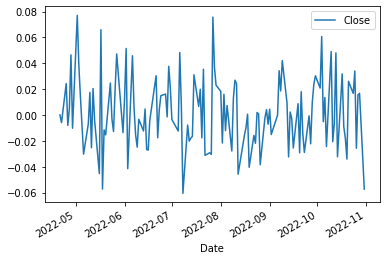

In [20]:
df_testing.plot()

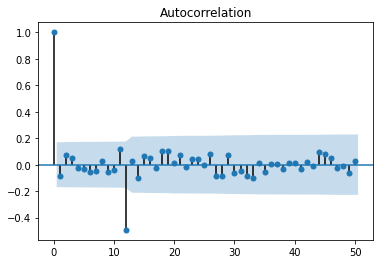

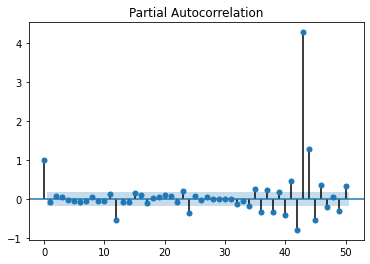

In [21]:
ACF = plot_acf(df_testing.dropna(),lags=50)
PACF = plot_pacf(df_testing.dropna(),lags=50)

**Fitting AR model on our dataset**

In [22]:
best_RMSE=100000000000
best_p = -1

for i in range(1,21):
  [df_train,df_test,theta,intercept,RMSE] = AR(i,pd.DataFrame(df_testing.Close))
  if(RMSE<best_RMSE):
    best_RMSE = RMSE
    best_p = i
print(best_p)

The RMSE is : 0.028302508311393942 , Value of p :  1
The RMSE is : 0.028147160462950762 , Value of p :  2
The RMSE is : 0.028086990309339054 , Value of p :  3
The RMSE is : 0.02808687123172078 , Value of p :  4
The RMSE is : 0.028069595891163236 , Value of p :  5
The RMSE is : 0.027940958098367802 , Value of p :  6
The RMSE is : 0.028172506268060202 , Value of p :  7
The RMSE is : 0.028565384681222147 , Value of p :  8
The RMSE is : 0.02849472023049273 , Value of p :  9
The RMSE is : 0.028595076593329348 , Value of p :  10
The RMSE is : 0.028461522782115167 , Value of p :  11
The RMSE is : 0.023260740134648166 , Value of p :  12
The RMSE is : 0.023341172006972923 , Value of p :  13
The RMSE is : 0.02368075652014676 , Value of p :  14
The RMSE is : 0.023208328186758505 , Value of p :  15
The RMSE is : 0.022818258753683335 , Value of p :  16
The RMSE is : 0.023373337759444605 , Value of p :  17
The RMSE is : 0.023427767315673267 , Value of p :  18
The RMSE is : 0.02476657329347076 , Valu

In [23]:
[df_train,df_test,theta,intercept,RMSE] = AR(best_p,pd.DataFrame(df_testing.Close))

The RMSE is : 0.022818258753683335 , Value of p :  16


In [24]:
df_test.head()


,Close,Shifted_values_1,Shifted_values_2,Shifted_values_3,Shifted_values_4,Shifted_values_5,Shifted_values_6,Shifted_values_7,Shifted_values_8,Shifted_values_9,Shifted_values_10,Shifted_values_11,Shifted_values_12,Shifted_values_13,Shifted_values_14,Shifted_values_15,Shifted_values_16,Predicted_Values
Date,,,,,,,,,,,,,,,,,,
2022-09-20,-0.029192,0.008803,-0.025489,-0.002667,0.002356,-0.032340,0.009400,0.042129,0.018643,0.034280,-0.000108,-0.015096,0.004549,-0.007079,0.004160,-0.002153,-0.038420,-0.010646
2022-09-21,0.018078,-0.029192,0.008803,-0.025489,-0.002667,0.002356,-0.032340,0.009400,0.042129,0.018643,0.034280,-0.000108,-0.015096,0.004549,-0.007079,0.004160,-0.002153,0.009101
2022-09-22,-0.014079,0.018078,-0.029192,0.008803,-0.025489,-0.002667,0.002356,-0.032340,0.009400,0.042129,0.018643,0.034280,-0.000108,-0.015096,0.004549,-0.007079,0.004160,0.006670
2022-09-23,-0.028925,-0.014079,0.018078,-0.029192,0.008803,-0.025489,-0.002667,0.002356,-0.032340,0.009400,0.042129,0.018643,0.034280,-0.000108,-0.015096,0.004549,-0.007079,-0.010364
2022-09-26,-0.000606,-0.028925,-0.014079,0.018078,-0.029192,0.008803,-0.025489,-0.002667,0.002356,-0.032340,0.009400,0.042129,0.018643,0.034280,-0.000108,-0.015096,0.004549,-0.006270


Comparing actual close prices with our predicted close prices using our AR model

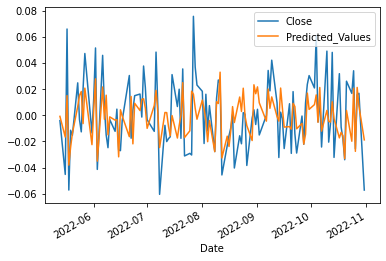

In [25]:
df_c = pd.concat([df_train,df_test])
df_c[['Close','Predicted_Values']].plot()

Generating a dataframe with the residual values from our AR model's predicted values.

In [26]:
res = pd.DataFrame()
res['Residuals'] = df_c.Close - df_c.Predicted_Values
res.head()

,Residuals
Date,
2022-05-13,-0.003254
2022-05-16,-0.028587
2022-05-17,0.050967
2022-05-18,-0.019087
2022-05-19,0.013096


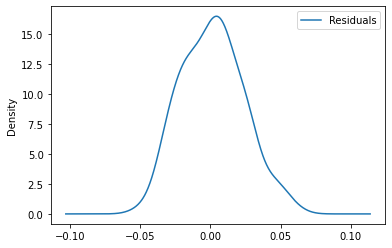

In [27]:
res.plot(kind='kde')

**Fitting MA Model on Residuals**

The RMSE is : 0.0246668350875469 , Value of q :  1
The RMSE is : 0.024298494472759304 , Value of q :  2
The RMSE is : 0.02482079755849769 , Value of q :  3
The RMSE is : 0.024903008496912907 , Value of q :  4
The RMSE is : 0.025368521250290786 , Value of q :  5
The RMSE is : 0.02539003609678873 , Value of q :  6
The RMSE is : 0.02519166732103202 , Value of q :  7
The RMSE is : 0.02517567766524574 , Value of q :  8
The RMSE is : 0.024618283246468142 , Value of q :  9
The RMSE is : 0.02496153893211427 , Value of q :  10
The RMSE is : 0.02462676438690997 , Value of q :  11
The RMSE is : 0.023827369661464964 , Value of q :  12
12


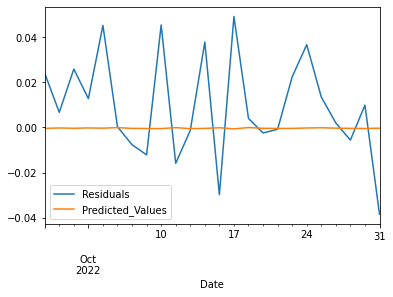

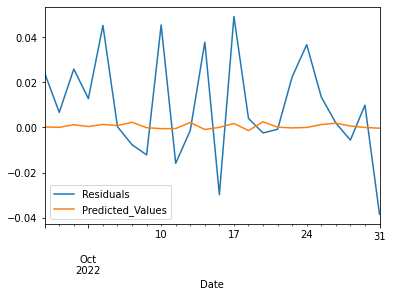

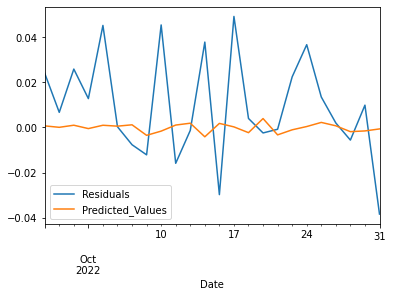

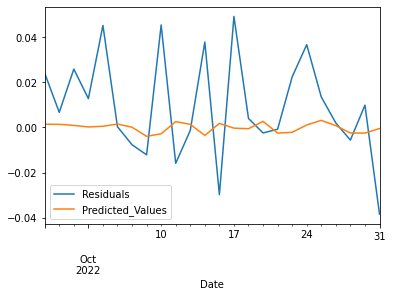

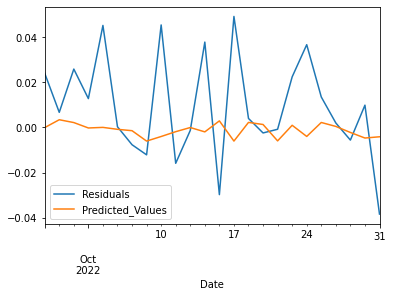

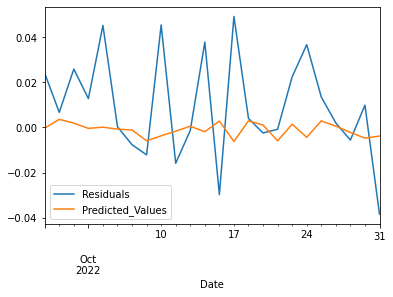

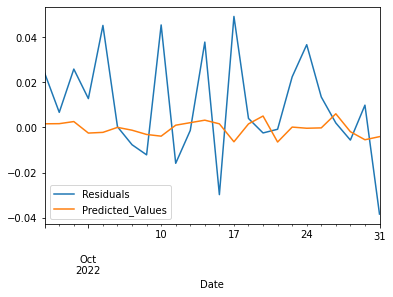

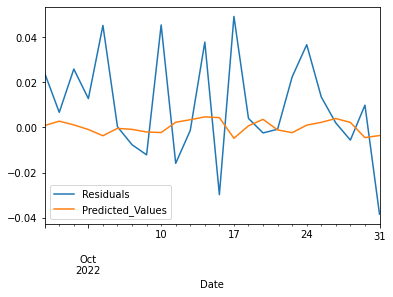

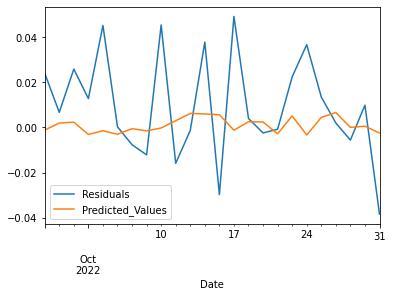

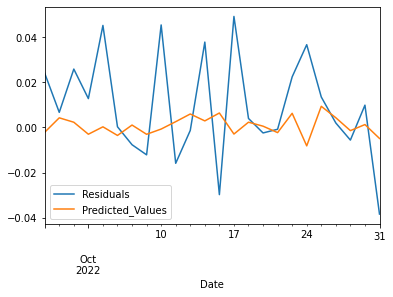

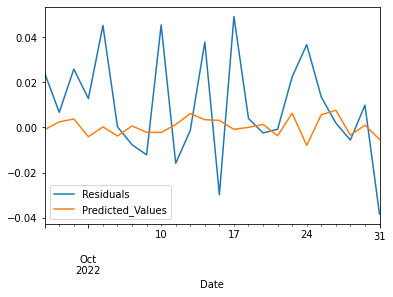

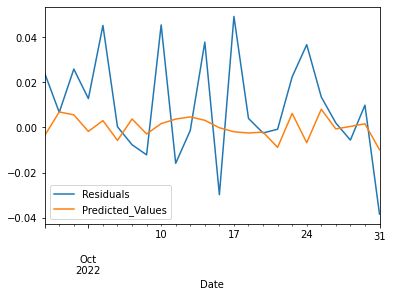

In [28]:
best_RMSE=100000000000
best_q = -1

for i in range(1,13):
  [res_train,res_test,theta,intercept,RMSE] = MA(i,pd.DataFrame(res.Residuals))
  if(RMSE<best_RMSE):
    best_RMSE = RMSE
    best_q = i
  
print(best_q)

The RMSE is : 0.023827369661464964 , Value of q :  12
[[ 0.05360629]
 [ 0.06096885]
 [-0.00214131]
 [-0.0293589 ]
 [-0.08965413]
 [ 0.05573051]
 [ 0.02832758]
 [ 0.05945472]
 [ 0.09827932]
 [-0.0348595 ]
 [-0.01136175]
 [-0.14882007]]
[-0.00086889]


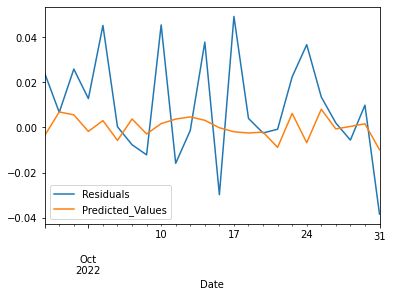

In [29]:
[res_train,res_test,theta,intercept,RMSE] = MA(best_q,pd.DataFrame(res.Residuals))
print(theta)
print(intercept)

In [30]:
res_c = pd.concat([res_train,res_test])


Comparing actual close prices with our predicted close prices using our MA model

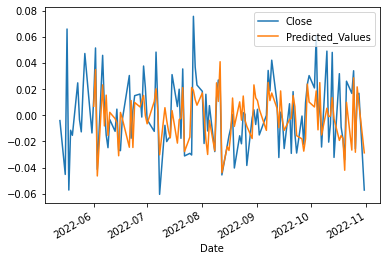

In [31]:
df_c.Predicted_Values += res_c.Predicted_Values
df_c[['Close','Predicted_Values']].plot()

Getting Back to Original Data

Reversing the steps performed for differencing, as a check the first column (Close) must be the same after reversing the steps

In [33]:
df_c.Close += np.log(df).shift(1).Close
df_c.Close += np.log(df).diff().shift(12).Close
df_c.Predicted_Values += np.log(df).shift(1).Close
df_c.Predicted_Values += np.log(df).diff().shift(12).Close
df_c.Close = np.exp(df_c.Close)
df_c.Predicted_Values = np.exp(df_c.Predicted_Values)
df_c.head()

,Close,Shifted_values_1,Shifted_values_2,Shifted_values_3,Shifted_values_4,Shifted_values_5,Shifted_values_6,Shifted_values_7,Shifted_values_8,Shifted_values_9,Shifted_values_10,Shifted_values_11,Shifted_values_12,Shifted_values_13,Shifted_values_14,Shifted_values_15,Shifted_values_16,Predicted_Values
Date,,,,,,,,,,,,,,,,,,
2022-05-13,5.466763e+09,0.020474,-0.025248,0.017487,-0.006846,-0.030228,-0.007830,0.014229,0.038526,0.077085,-0.010170,0.046520,0.005050,-0.008033,0.024337,-0.005860,0.000065,NaN
2022-05-16,3.331066e+09,-0.004105,0.020474,-0.025248,0.017487,-0.006846,-0.030228,-0.007830,0.014229,0.038526,0.077085,-0.010170,0.046520,0.005050,-0.008033,0.024337,-0.005860,NaN
2022-05-17,6.030302e+09,-0.045281,-0.004105,0.020474,-0.025248,0.017487,-0.006846,-0.030228,-0.007830,0.014229,0.038526,0.077085,-0.010170,0.046520,0.005050,-0.008033,0.024337,NaN
2022-05-18,2.848429e+09,0.065977,-0.045281,-0.004105,0.020474,-0.025248,0.017487,-0.006846,-0.030228,-0.007830,0.014229,0.038526,0.077085,-0.010170,0.046520,0.005050,-0.008033,NaN
2022-05-19,2.323312e+09,-0.057240,0.065977,-0.045281,-0.004105,0.020474,-0.025248,0.017487,-0.006846,-0.030228,-0.007830,0.014229,0.038526,0.077085,-0.010170,0.046520,0.005050,NaN


**Visualizing the final ARMA model performance on our testing data**

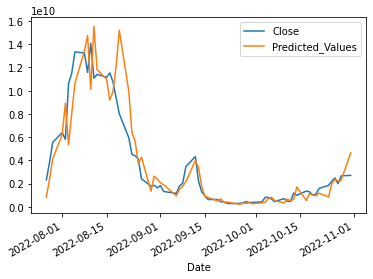

In [34]:
df_c.iloc[50:,:][['Close','Predicted_Values']].plot()

We could visualize that our model has a good accuracy in predicting the correct trend of the target values i.e., the close price values.
